In [1]:
!pip install opendatasets

In [2]:
import tensorflow as tf
import opendatasets as od
import tensorflow_datasets as tfds
from tensorflow import keras
import matplotlib.pyplot as plt
import numpy as np
from PIL import Image, ImageOps

In [3]:
# Загрузка датасета
data = od.download(
    "https://www.kaggle.com/datasets/andrewmvd/doom-crossing/data")

Please provide your Kaggle credentials to download this dataset. Learn more: http://bit.ly/kaggle-creds
Your Kaggle username: indall
Your Kaggle Key: ··········
Dataset URL: https://www.kaggle.com/datasets/andrewmvd/doom-crossing


100%|██████████| 997M/997M [00:03<00:00, 290MB/s]


In [4]:
BATCH_SIZE = 32
IMG_WIDTH = 64
IMG_HEIGHT = 64
IMG_CHANNELS = 3
IMG_SHAPE = (IMG_WIDTH, IMG_HEIGHT, IMG_CHANNELS)

doom_color = '#B9121B'
ac_color = '#3CAEA3'

initial_epochs = 5

In [5]:
data = tf.keras.utils.image_dataset_from_directory('/content/doom-crossing', image_size=(IMG_WIDTH, IMG_HEIGHT), batch_size=BATCH_SIZE)

# Нормализируем данные
data = data.map(lambda x, y: (x / 255, y))

Found 1597 files belonging to 2 classes.


Получим ЧБ датасет из исходного

In [6]:
def rgb_to_grayscale(images, labels):
    # images: tf.Tensor shape=(BATCH, 64, 64, 3)
    gray = tf.image.rgb_to_grayscale(images)  # даёт (BATCH, 64, 64, 1)
    gray = tf.image.grayscale_to_rgb(gray) # Но модель ожидает другой вход shape=(BATCH, 64, 64, 3) поэтому забиваем канал
    return gray, labels

gray_data = data.map(rgb_to_grayscale)

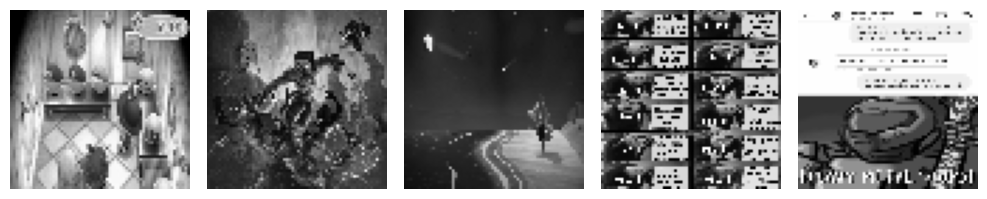

In [15]:
def plot_reconstructions(dataset, n_images=5):
    plt.figure(figsize=(10, 4))
    for images, _ in dataset.take(1):
        for i in range(n_images):
            ax = plt.subplot(2, n_images, i + 1)
            plt.imshow(images[i], cmap="gray")
            plt.axis("off")
    plt.tight_layout()
    plt.show()

plot_reconstructions(gray_data)

In [7]:
train_size_percentage = 0.7
val_size_percentage = 0.2
test_size_percentage = 0.1

spared_batches = len(gray_data) % 10

train_size = int(len(gray_data) * train_size_percentage)
val_size = int(len(gray_data) * val_size_percentage)
test_size = int(len(gray_data) * test_size_percentage) + spared_batches

train_gray = gray_data.take(train_size)
val_gray = gray_data.skip(train_size).take(val_size)
test_gray = gray_data.skip(train_size + val_size).take(test_size)

Датасет цветной

In [8]:
train_size_percentage = 0.7
val_size_percentage = 0.2
test_size_percentage = 0.1

spared_batches = len(data) % 10

train_size = int(len(data) * train_size_percentage)
val_size = int(len(data) * val_size_percentage)
test_size = int(len(data) * test_size_percentage) + spared_batches

train = data.take(train_size)
val = data.skip(train_size).take(val_size)
test = data.skip(train_size + val_size).take(test_size)

In [9]:
def train_model(model, train, val, initial_epochs, callbacks):
    hist = model.fit(train,
                     epochs=initial_epochs,
                     validation_data=val,
                     callbacks=[tensorboard_callback])

    # График функции потерь
    fig = plt.figure()
    plt.plot(hist.history['loss'], color=doom_color, label='loss')
    plt.plot(hist.history['val_loss'], color=ac_color, label='val_loss')
    fig.suptitle('Loss', fontsize=20)
    plt.legend(loc="upper left")
    plt.show()

    # График точности
    fig = plt.figure()
    plt.plot(hist.history['accuracy'], color=doom_color, label='accuracy')
    plt.plot(hist.history['val_accuracy'], color=ac_color, label='val_accuracy')
    fig.suptitle('Accuracy', fontsize=20)
    plt.legend(loc="upper left")
    plt.show()

In [10]:
def test_model(model, test):
    y_true = []
    y_pred = []

    precision = tf.keras.metrics.Precision()
    recall = tf.keras.metrics.Recall()
    binary_accuracy = tf.keras.metrics.BinaryAccuracy()

    for batch in test.as_numpy_iterator():
        X, y = batch
        yhat = model.predict(X)

        y_true.extend(y)
        y_pred.extend((yhat > 0.5).astype(int))

        precision.update_state(y, yhat)
        recall.update_state(y, yhat)
        binary_accuracy.update_state(y, yhat)

    print(f'Precision: {precision.result():.2f}, Recall: {recall.result():.2f}, Binary Accuracy: {binary_accuracy.result():.2f}')

In [21]:
modelA = tf.keras.Sequential([
    tf.keras.layers.Conv2D(16, (3,3), 1, activation='relu', input_shape=IMG_SHAPE),
    tf.keras.layers.MaxPooling2D(),
    tf.keras.layers.Conv2D(32, (3,3), 1, activation='relu'),
    tf.keras.layers.MaxPooling2D(),

    tf.keras.layers.Conv2D(16, (3,3), 1, activation='relu'),
    tf.keras.layers.MaxPooling2D(),

    tf.keras.layers.Flatten(),

    tf.keras.layers.Dense(256, activation='relu'),
    tf.keras.layers.Dense(1, activation='sigmoid')
  ])

/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [22]:
# Сохраняем данные об обучении
logdir='logs'
tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=logdir)

Обучаем на ЧБ датасете

Epoch 1/5
35/35 ━━━━━━━━━━━━━━━━━━━━ 59s 2s/step - accuracy: 0.4775 - loss: 0.6948 - precision: 0.5084 - recall: 0.5191 - val_accuracy: 0.5312 - val_loss: 0.6698 - val_precision: 0.5253 - val_recall: 1.0000
Epoch 2/5
35/35 ━━━━━━━━━━━━━━━━━━━━ 67s 2s/step - accuracy: 0.6070 - loss: 0.6684 - precision: 0.5947 - recall: 0.8580 - val_accuracy: 0.6000 - val_loss: 0.6531 - val_precision: 0.5576 - val_recall: 0.9688
Epoch 3/5
35/35 ━━━━━━━━━━━━━━━━━━━━ 59s 2s/step - accuracy: 0.6516 - loss: 0.6404 - precision: 0.6278 - recall: 0.8177 - val_accuracy: 0.7344 - val_loss: 0.5809 - val_precision: 0.7296 - val_recall: 0.8171
Epoch 4/5
35/35 ━━━━━━━━━━━━━━━━━━━━ 67s 2s/step - accuracy: 0.7121 - loss: 0.6077 - precision: 0.7109 - recall: 0.7367 - val_accuracy: 0.7000 - val_loss: 0.5683 - val_precision: 0.6757 - val_recall: 0.7764
Epoch 5/5
35/35 ━━━━━━━━━━━━━━━━━━━━ 66s 2s/step - accuracy: 0.7392 - loss: 0.5762 - precision: 0.7337 - recall: 0.7719 - val_accuracy: 0.7437 - val_loss: 0.5433 - val_prec

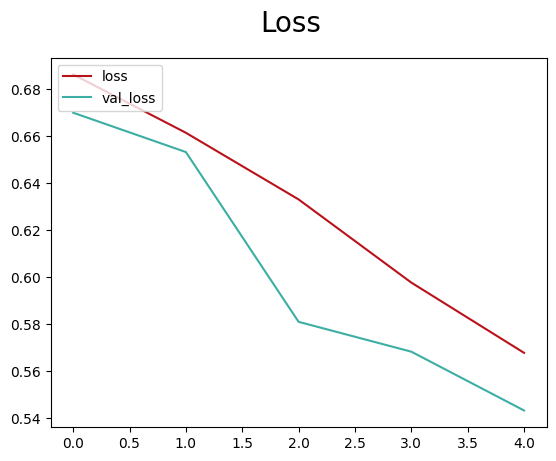

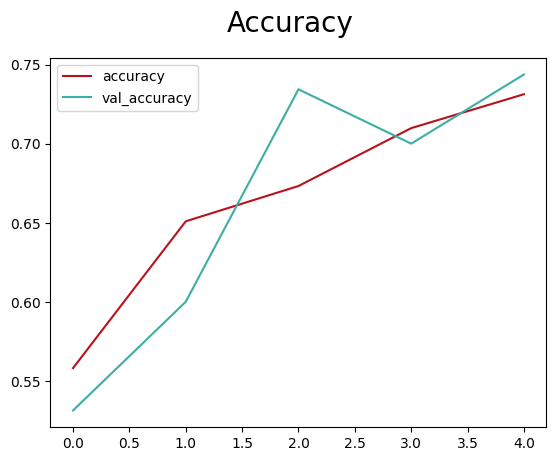

In [23]:
train_model(modelA, train_gray, val_gray, initial_epochs, tensorboard_callback)

In [24]:
test_model(modelA, test_gray)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 379ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 123ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 196ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 156ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 139ms/step
Precision: 0.78, Recall: 0.77, Binary Accuracy: 0.75


In [32]:
modelA.save("modelA.h5")

In [50]:
modelA.summary()

Model: "sequential_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ sequential_2 (Sequential)       │ (None, 6, 6, 16)       │         9,712 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_2 (Flatten)             │ (None, 576)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 256)            │       147,712 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ (None, 1)              │           257 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 157,681 (615.94 KB)

 Trainable params: 157,681 (615.94 KB)

 Non-trainable params: 0 (0.00 B)

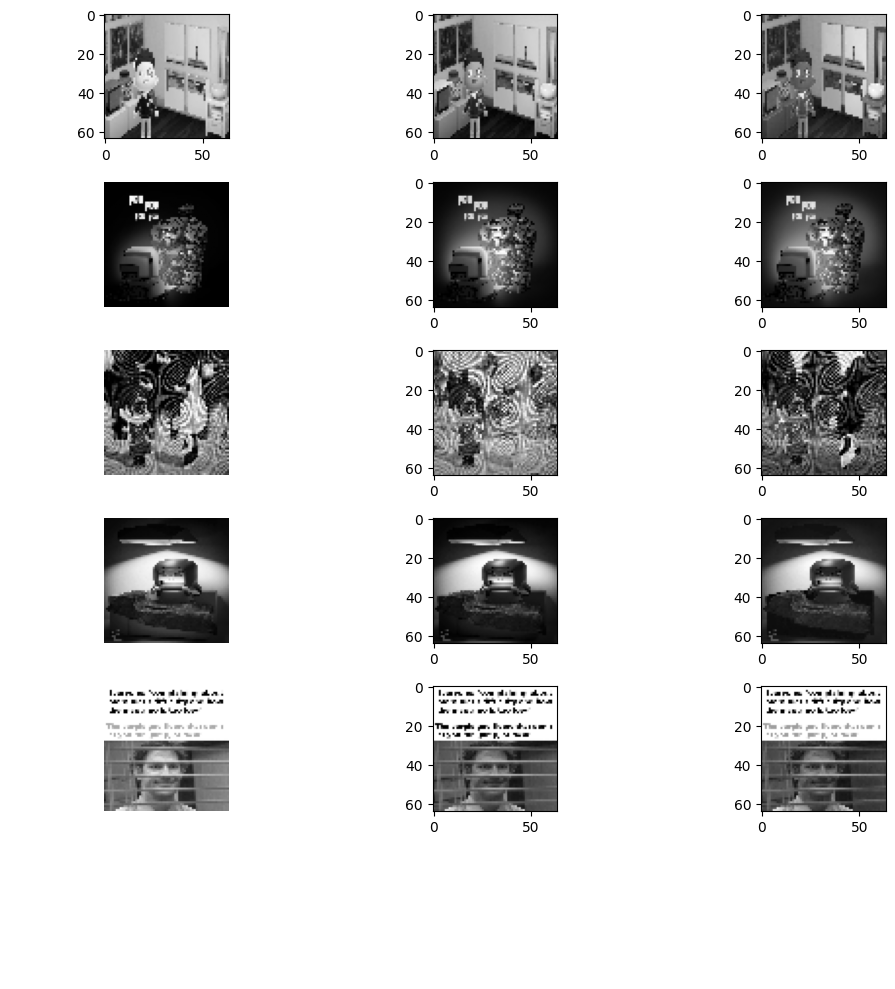

In [25]:
def plot_reconstructions(dataset1, dataset2, n_images=5):
    plt.figure(figsize=(10, 10))
    for images, _ in dataset1.take(1):
        for i in range(n_images):
            ax = plt.subplot(6, 3, i*3 + 1)
            plt.imshow(np.asarray(images[i])[:,:,0], cmap="gray")
            ax = plt.subplot(6, 3, i*3 + 2)
            plt.imshow(np.asarray(images[i])[:,:,1], cmap="gray")
            ax = plt.subplot(6, 3, i*3 + 3)
            plt.imshow(np.asarray(images[i])[:,:,2], cmap="gray")
            ax = plt.subplot(6, 3, i*3 + 4)
            plt.axis("off")
    plt.tight_layout()
    plt.show()

plot_reconstructions(data, gray_data)

Эксперемент нумер раз "Прямое использование модели, обученной для решения
исходной «Задачи А», для решения целевой «Задачи В»."


In [26]:
test_model(modelA, test)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 126ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 128ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 163ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 102ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step
Precision: 0.78, Recall: 0.78, Binary Accuracy: 0.76


Эксперимент нумер два. Использование структуры глубокой модели,
построенной для решения исходной «Задачи А», с целью
обучения аналогичной модели для решения «Задачи В»

Epoch 1/5
35/35 ━━━━━━━━━━━━━━━━━━━━ 69s 2s/step - accuracy: 0.6885 - loss: 0.6147 - precision: 0.6870 - recall: 0.7055 - val_accuracy: 0.7312 - val_loss: 0.5206 - val_precision: 0.7387 - val_recall: 0.8122
Epoch 2/5
35/35 ━━━━━━━━━━━━━━━━━━━━ 54s 2s/step - accuracy: 0.7211 - loss: 0.5732 - precision: 0.7149 - recall: 0.7773 - val_accuracy: 0.7063 - val_loss: 0.5668 - val_precision: 0.6681 - val_recall: 0.8882
Epoch 3/5
35/35 ━━━━━━━━━━━━━━━━━━━━ 53s 2s/step - accuracy: 0.7280 - loss: 0.5655 - precision: 0.7191 - recall: 0.7687 - val_accuracy: 0.7063 - val_loss: 0.5553 - val_precision: 0.7200 - val_recall: 0.7368
Epoch 4/5
35/35 ━━━━━━━━━━━━━━━━━━━━ 82s 2s/step - accuracy: 0.7229 - loss: 0.5501 - precision: 0.7301 - recall: 0.7416 - val_accuracy: 0.7312 - val_loss: 0.5262 - val_precision: 0.6804 - val_recall: 0.9030
Epoch 5/5
35/35 ━━━━━━━━━━━━━━━━━━━━ 56s 2s/step - accuracy: 0.7551 - loss: 0.5424 - precision: 0.7525 - recall: 0.7764 - val_accuracy: 0.7531 - val_loss: 0.5072 - val_prec

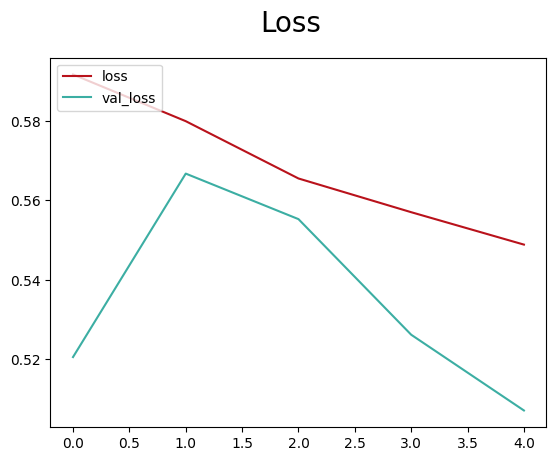

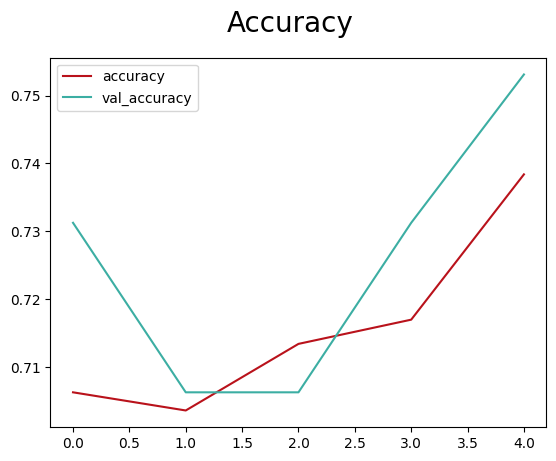

In [33]:
modelB = tf.keras.models.load_model('modelA.h5')
train_model(modelB, train, val, initial_epochs, tensorboard_callback)

In [34]:
test_model(modelB, test)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 414ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 169ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 97ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 276ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 206ms/step
Precision: 0.88, Recall: 0.70, Binary Accuracy: 0.79


Использование модели, построенной для решения
исходной «Задачи А», в качестве фиксированного
метода извлечения признаков при построении модели,
решающей «Задачу В»

In [35]:
model_kern = tf.keras.Sequential([
    tf.keras.layers.Conv2D(16, (3,3), 1, activation='relu', input_shape=IMG_SHAPE),
    tf.keras.layers.MaxPooling2D(),
    tf.keras.layers.Conv2D(32, (3,3), 1, activation='relu'),
    tf.keras.layers.MaxPooling2D(),

    tf.keras.layers.Conv2D(16, (3,3), 1, activation='relu'),
    tf.keras.layers.MaxPooling2D()
  ])

/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [37]:
modelС = tf.keras.Sequential([
    model_kern,
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(256, activation='relu'),
    tf.keras.layers.Dense(1, activation='sigmoid')
  ])

Epoch 1/5
35/35 ━━━━━━━━━━━━━━━━━━━━ 74s 2s/step - accuracy: 0.5642 - loss: 0.6799 - precision: 0.5324 - recall: 0.3052 - val_accuracy: 0.7156 - val_loss: 0.6540 - val_precision: 0.8411 - val_recall: 0.5488
Epoch 2/5
35/35 ━━━━━━━━━━━━━━━━━━━━ 60s 2s/step - accuracy: 0.6807 - loss: 0.6505 - precision: 0.7329 - recall: 0.5934 - val_accuracy: 0.7063 - val_loss: 0.6166 - val_precision: 0.7232 - val_recall: 0.7399
Epoch 3/5
35/35 ━━━━━━━━━━━━━━━━━━━━ 93s 2s/step - accuracy: 0.6987 - loss: 0.6202 - precision: 0.7457 - recall: 0.6302 - val_accuracy: 0.7156 - val_loss: 0.5738 - val_precision: 0.7014 - val_recall: 0.8409
Epoch 4/5
35/35 ━━━━━━━━━━━━━━━━━━━━ 78s 2s/step - accuracy: 0.6993 - loss: 0.6030 - precision: 0.6980 - recall: 0.6965 - val_accuracy: 0.7250 - val_loss: 0.5592 - val_precision: 0.7931 - val_recall: 0.6647
Epoch 5/5
35/35 ━━━━━━━━━━━━━━━━━━━━ 61s 2s/step - accuracy: 0.6925 - loss: 0.6023 - precision: 0.7284 - recall: 0.6295 - val_accuracy: 0.7375 - val_loss: 0.5471 - val_prec

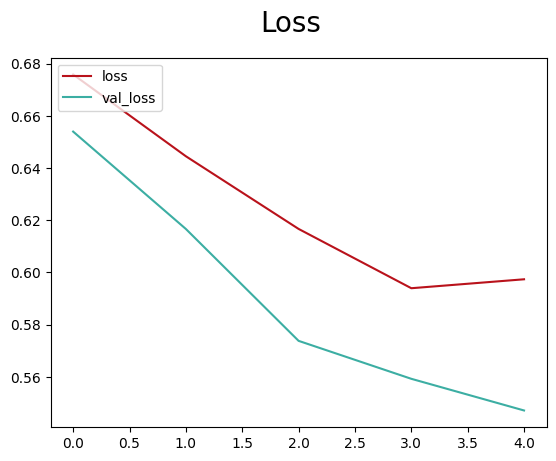

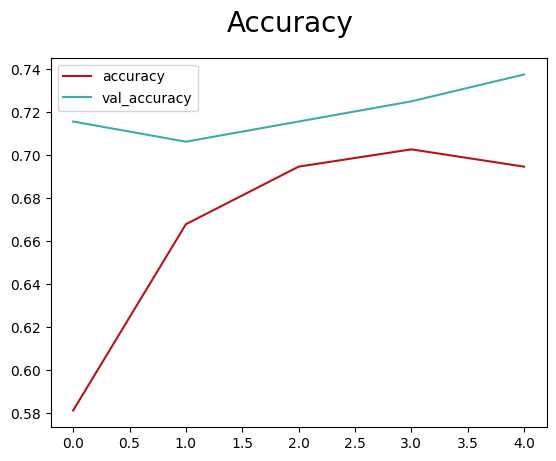

In [38]:
train_model(modelС, train, val, initial_epochs, tensorboard_callback)

In [39]:
test_model(modelС, test)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 316ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 163ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 178ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 162ms/step


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 137ms/step
Precision: 0.78, Recall: 0.75, Binary Accuracy: 0.75


Возьмем натренированную модель EfficientNetB0 для решения исходной задачи.

In [41]:
from tensorflow.keras.applications import EfficientNetB0

base_model = EfficientNetB0(
    weights='imagenet',
    include_top=False,
    input_shape=IMG_SHAPE
)

base_model.trainable = False  # замораживаем основу

16705208/16705208 ━━━━━━━━━━━━━━━━━━━━ 1s 0us/step


In [44]:
inputs = tf.keras.layers.Input(shape=IMG_SHAPE)
x = base_model(inputs, training=False)
x = tf.keras.layers.GlobalAveragePooling2D()(x)
x = tf.keras.layers.Dropout(0.3)(x)
outputs = tf.keras.layers.Dense(1, activation='sigmoid')(x)
model = tf.keras.models.Model(inputs, outputs)

Epoch 1/5
35/35 ━━━━━━━━━━━━━━━━━━━━ 90s 2s/step - accuracy: 0.5120 - loss: 0.7003 - precision: 0.5158 - recall: 0.7342 - val_accuracy: 0.5281 - val_loss: 0.6914 - val_precision: 0.5281 - val_recall: 1.0000
Epoch 2/5
35/35 ━━━━━━━━━━━━━━━━━━━━ 55s 2s/step - accuracy: 0.5172 - loss: 0.6964 - precision: 0.5185 - recall: 0.6401 - val_accuracy: 0.5344 - val_loss: 0.6906 - val_precision: 0.5344 - val_recall: 1.0000
Epoch 3/5
35/35 ━━━━━━━━━━━━━━━━━━━━ 56s 2s/step - accuracy: 0.5308 - loss: 0.6976 - precision: 0.5308 - recall: 0.7321 - val_accuracy: 0.5344 - val_loss: 0.6905 - val_precision: 0.5344 - val_recall: 1.0000
Epoch 4/5
35/35 ━━━━━━━━━━━━━━━━━━━━ 67s 2s/step - accuracy: 0.4947 - loss: 0.7018 - precision: 0.5133 - recall: 0.7296 - val_accuracy: 0.4938 - val_loss: 0.6967 - val_precision: 0.4938 - val_recall: 1.0000
Epoch 5/5
35/35 ━━━━━━━━━━━━━━━━━━━━ 76s 2s/step - accuracy: 0.4988 - loss: 0.7016 - precision: 0.5069 - recall: 0.7448 - val_accuracy: 0.5188 - val_loss: 0.6925 - val_prec

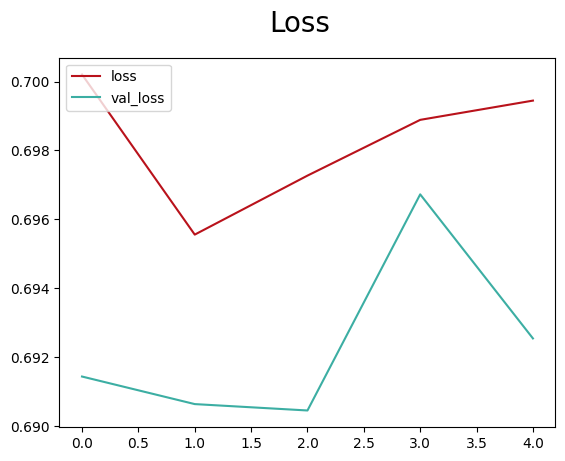

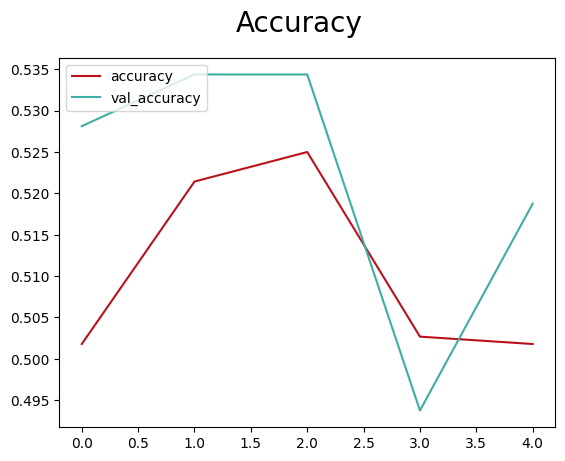

In [45]:
train_model(model, train_gray, val_gray, initial_epochs, tensorboard_callback)

In [48]:
test_model(model, test_gray)

1/1 ━━━━━━━━━━━━━━━━━━━━ 5s 5s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 257ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 182ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 181ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step
Precision: 0.54, Recall: 1.00, Binary Accuracy: 0.54


In [46]:
base_model.trainable = True

# Дообучим последние слои
for layer in base_model.layers[:100]:
    layer.trainable = False

Epoch 1/5
35/35 ━━━━━━━━━━━━━━━━━━━━ 113s 2s/step - accuracy: 0.5224 - loss: 0.7400 - precision: 0.5457 - recall: 0.5934 - val_accuracy: 0.5094 - val_loss: 0.6990 - val_precision: 0.5094 - val_recall: 1.0000
Epoch 2/5
35/35 ━━━━━━━━━━━━━━━━━━━━ 62s 2s/step - accuracy: 0.6266 - loss: 0.6491 - precision: 0.6099 - recall: 0.6576 - val_accuracy: 0.4688 - val_loss: 0.7068 - val_precision: 0.4688 - val_recall: 1.0000
Epoch 3/5
35/35 ━━━━━━━━━━━━━━━━━━━━ 64s 2s/step - accuracy: 0.6625 - loss: 0.6382 - precision: 0.6608 - recall: 0.6979 - val_accuracy: 0.5406 - val_loss: 0.6970 - val_precision: 0.5406 - val_recall: 1.0000
Epoch 4/5
35/35 ━━━━━━━━━━━━━━━━━━━━ 77s 2s/step - accuracy: 0.6900 - loss: 0.5934 - precision: 0.7065 - recall: 0.7097 - val_accuracy: 0.5094 - val_loss: 0.7374 - val_precision: 0.5094 - val_recall: 1.0000
Epoch 5/5
35/35 ━━━━━━━━━━━━━━━━━━━━ 66s 2s/step - accuracy: 0.6814 - loss: 0.5862 - precision: 0.6629 - recall: 0.7331 - val_accuracy: 0.5500 - val_loss: 0.7253 - val_pre

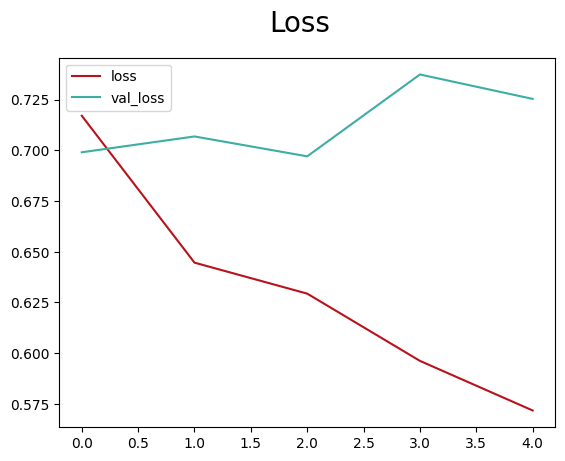

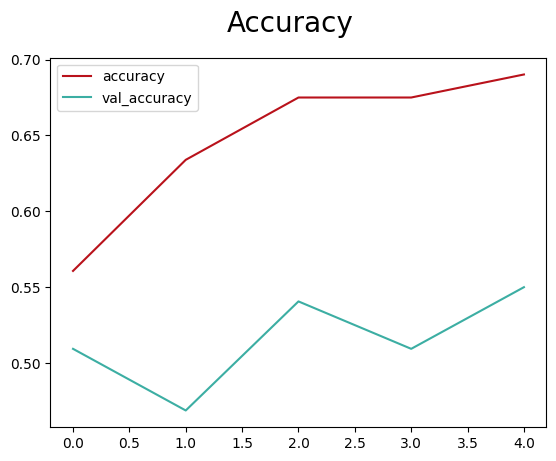

In [47]:
train_model(model, train, val, initial_epochs, tensorboard_callback)

In [49]:
test_model(model, test)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 382ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 667ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 614ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 564ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 165ms/step
Precision: 0.53, Recall: 1.00, Binary Accuracy: 0.53
